In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import scipy.integrate

import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import griddata

import matplotlib.pyplot as plt

import math

import random

from mpmath import polylog

from sklearn.model_selection import train_test_split

import time

import itertools

In [2]:
def generate_data(func, lower, upper, params=[], n_samples=100, n_dim=1):
    """
    Generates data in the form of a 2D tensor of variables for the function and neural network input
    as well as the function values for the generated tensor of variables.

    @param func      function to provide values for the variables
    @param lower     lower bounds of variables (list, tensor or scalar)
    @param upper     upper bounds of variables (list, tensor or scalar)
    @param n_samples number of points of data to generate per dimension
                        (default value is 100)
    @param n_dim     number of dimensions of the function func
                        (default value is 1)

    @returns         variables x and function values y
    """
    if n_dim == 1:
        X = torch.linspace(lower, upper, n_samples).view(n_samples, 1)
        y = func(X).view(n_samples, 1)
        return X, y

    ranges = [torch.linspace(lower[n], upper[n], n_samples).tolist() for n in range(n_dim)]
    combinations = list(itertools.product(*ranges))
    X = torch.tensor(combinations, dtype=torch.float32)
    y = func(X).view(-1, 1)

    return X, y

In [3]:
class MLP(nn.Module):
    """
        Нейросеть, которая будет обучаться приближать функцию одной переменной.
        
        Нейросеть имеет архитектуру:

        Входной слой (1 нейрон для переменной функции + смещение, линейная функция активации)
        Скрытый слой (произвольное количество нейронов + смещение, функция активации - сигмоида)
        Выходной слой (1 нейрон для приближенного значения функции, линейная функция активации)
    """
    def __init__(self, input_size, hidden_size):
        """
            Конструктор для нейросети.
            @param self        нейросеть (необходим для включения в класс)
            @param hidden_size размер скрытого слоя (размеры входного и выходного слоёв равны одному
                               в рамках данной задачи, так как у функции одна переменная и 
                               задача сводится к описанию функции, то есть числа, скаляра).
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(input_size, hidden_size) # инициализация входного и скрытого слоя, 
                                                     # размеры: 1 --> размер скрытого слоя
        self.sigmoid_activation = nn.Sigmoid() # инициализация функции активации скрытого слоя
        self.output_layer = nn.Linear(hidden_size, 1) # инициализация выходного слоя, 
                                                      # размеры: размер скрытого слоя --> 1
    
    def forward(self, x):
        """
            Функция распространения данных через нейросеть вперёд.
           
            @param self   нейросеть (необходим для включения в класс)
            @param x      данные
           
            @returns выход в выходном нейроне
        """
        x = self.input_hidden_layer(x) # данные прошли входной слой и аккумулирвоаны в скрытом слое
        x = self.sigmoid_activation(x) # данные прошли функцию активации скрытого слоя
        x = self.output_layer(x) # данные прошли выходной слой
        
        return x


def train_model(model, criterion, optimizer, x_train, y_train, epochs, verbose=True):
    """
        Trains the model.
        
        @param model        The model to be trained
        @param criterion    Loss function
        @param optimizer    Optimization algorithm
        @param x_train      Training inputs
        @param y_train      True labels
        @param epochs       Number of training epochs
    """
    loss_history = [] # история обучения (изменения функции потерь)
    start_time = time.time()
    for epoch in range(epochs):
        predictions = model(x_train) # все переменные проводятся через нейросеть 
                                     # и формируются предскзания значений функции
        loss = criterion(predictions, y_train) # вычисляется функция потерь на данной эпохе

        optimizer.zero_grad() # обнуляются градиенты перед обратным распространением ошибки
        loss.backward() # обратное распространение ошибки
        optimizer.step() # шаг оптимизации - обновление параметров модели 

        loss_history.append(loss.item()) # запись текущей функции потерь

        if verbose:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}') # вывод информации об обучении
    total_time = time.time() - start_time  # Общее время обучения
    print(f'Training done! Time elapsed: {total_time:.2f} seconds')
    return loss_history # возвращается история обучения


def test_model(model, criterion, x_test, y_test):
    """
        Tests the model.
        
        @param model        The trained model
        @param criterion    Loss function
        @param x_test       Test inputs
        @param y_test       True labels
    """
    with torch.no_grad():  # отключение расчета градиентов 
                           # (расчет градиентов может происходить по умолчанию 
                           # даже без использования их потом, что излишне нагружает память)
        predictions = model(x_test)  # тестовые переменные проводятся через обученную модель
        loss = criterion(predictions, y_test)  # вычисляется функция потерь для тестового набора

    # Возвращаем вычисленную функцию потерь
    return loss.item()  # Возвращаем скалярное значение ошибки


def predict_with_model(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.
    
        @param model        The trained model
        @param x_test       Test inputs
    """
    with torch.no_grad():
        predictions = model(x_test)

    return predictions


def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy().flatten()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

def extract_model_params_2d(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

# Integration function

In [4]:
def get_NN_integral(alpha, beta, b1, w1, b2, w2):
    """
        Функция, реализующая метод численного интегрирования функции одной переменной
        на основе параметров нейросети. Реализует формулы (6.1) и (6.2).

        @param alpha нижняя граница интегрирования
        @param beta  верхняя граница интегрирования
        @param b1    смещения между входным и скрытым слоями
        @param w1    веса между входным и скрытым слоями
        @param b2    смещения между скрытым и выходным слоями
        @param w2    веса между скрытым и выходным слоями

        @returns численный интеграл на основе параметров нейросети.
    """
    def Phi_j(alpha, beta, b1_j, w1_j):
        """
            Вложенная функция, реализующая разность полилогарифмов (6.2).

            @param alpha нижняя граница интегрирования
            @param beta  верхняя граница интегрирования
            @param b1_j  j-е смещение между входным и скрытым слоями
            @param w1_j  j-тый вес между входным и скрытым слоями

            @returns разность полилогарифмов (6.2)
        """
        term_alpha = polylog(1, -np.exp(-b1_j - w1_j * alpha)) # расчет первого полилогарифма 1-го порядка
        term_beta = polylog(1, -np.exp(-b1_j - w1_j * beta)) # расчет второго полилогарифма 1-го порядка
        
        return term_alpha - term_beta # результат - разность первого и второго полилогарифмов

    integral_sum = 0 # сумма интеграллов 
    
    for w2_j, w1_j, b1_j in zip(w2, w1, b1):
        phi_j = Phi_j(alpha, beta, b1_j, w1_j) # рассчет разности полилогарифмов (6.2)
        integral_sum += w2_j * ((beta - alpha) + phi_j / w1_j) # аккумулирование интегралла для суммы в (6.1)
    
    return b2 * (beta - alpha) + integral_sum # результат полная формула численног метода (6.1)

def get_2D_NN_integral(alpha1, beta1, alpha2, beta2, b1, w1, b2, w2):

    """
        Функция, реализующая метод численного интегрирования функции одной переменной
        на основе параметров нейросети. Реализует формулы (6.1) и (6.2).

        @param alpha нижняя граница интегрирования
        @param beta  верхняя граница интегрирования
        @param b1    смещения между входным и скрытым слоями
        @param w1    веса между входным и скрытым слоями
        @param b2    смещения между скрытым и выходным слоями
        @param w2    веса между скрытым и выходным слоями

        @returns численный интеграл на основе параметров нейросети.
    """
    def Phi_j(alpha1, beta1, alpha2, beta2, b1_j, w1_1j, w1_2j):
        """
            Вложенная функция, реализующая разность полилогарифмов (6.2).

            @param alpha нижняя граница интегрирования
            @param beta  верхняя граница интегрирования
            @param b1_j  j-е смещение между входным и скрытым слоями
            @param w1_j  j-тый вес между входным и скрытым слоями

            @returns разность полилогарифмов (6.2)
        """
        term_1 = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * alpha2))
        term_2 = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * beta2))
        term_3 = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * alpha2))
        term_4 = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * beta2))
        
        return term_1 - term_2 - term_3 + term_4
   
    integral_sum = 0 
        
    for w2_j, w1_1j, w1_2j, b1_j in zip(w2, w1[:, 0], w1[:, 1], b1):
        phi_j = Phi_j(alpha1, beta1, alpha2, beta2, b1_j, w1_1j, w1_2j) 
        summ = w2_j * ((beta1 - alpha1) * (beta2 - alpha2) + phi_j / (w1_1j * w1_2j))
        integral_sum += summ
    
    return b2 * (beta1 - alpha1) * (beta2 - alpha2) + integral_sum 

# Hyperparams

In [5]:
input_size = 1
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

a = 0.0
b = 1.0

# Oscillatory 1D: Example

In [6]:
def osc_1d(X):
    return torch.cos(2 * math.pi * u + X * c)

def osc_1d_float(X):
    return math.cos(2 * math.pi * u + X * c)

In [7]:
u = random.uniform(0, 1)
cs = random.uniform(0, 1)
c = cs

In [8]:
X, y = generate_data(osc_1d, params=[u,c], lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

TypeError: linspace() received an invalid combination of arguments - got (list, list, int), but expected one of:
 * (Tensor start, Tensor end, int steps, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (Number start, Tensor end, int steps, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (Tensor start, Number end, int steps, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (Number start, Number end, int steps, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
x_np = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Oscillatory 1D')
plt.grid(True)
plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Model

### Hyperparams for the NN model

In [ ]:
input_size = 1
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### Model definition, compilation and training

In [ ]:
model = MLP(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs)

In [ ]:
summary(model, (input_size,)) # (input_size, ) - input shape

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for Oscillatory 1D')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [ ]:
test_loss = test_model(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

In [ ]:
bs1, we1, bs2, we2 = extract_model_params(model)

In [ ]:
a = 0.0
b = 1.0

In [ ]:
nni = get_NN_integral(a, b, bs1, we1, bs2, we2)

nni

In [ ]:
result, error = scipy.integrate.quad(osc_1d_float, a, b)

print("Integral:", result)
print("Error:", error)

In [ ]:
abs(float(nni[0]) - result)

# Oscillatory 1D

In [ ]:
def test_osc_1d(iteration_index: int, h: float):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0, 1)
    c = h # / cs
    
    def osc_1d(X):
        return torch.cos(2 * math.pi * u + X * c)

    def osc_1d_float(X):
        return math.cos(2 * math.pi * u + X * c)
  
    X, y = generate_data(osc_1d, params=[u, c], lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Oscillatory 1D")
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

In [ ]:
results = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results.append(test_osc_1d(i, h=100))

In [14]:
def plot_test_results(results: list):
    x_values = [i for i, _ in enumerate(results)]  # Index as x-axis
    nnis = [v1 for v1, v2, v3 in results]
    quads = [v2 for v1, v2, v3 in results]
    trapz = [v3 for v1, v2, v3 in results]
    abs_err_quad = [abs(v1 - v2) for v1, v2, v3 in results]
    abs_err_trapz = [abs(v1 - v3) for v1, v2, v3 in results]
    
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))
    
    ax1.plot(x_values, nnis, label='nnis', marker='o')
    ax1.plot(x_values, quads, label='quads', marker='x')
    ax1.plot(x_values, trapz, label='trapz', marker='s')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Integrals')
    ax1.set_title('Numerical integral values')
    ax1.legend()
    
    ax2.plot(x_values, abs_err_quad, label='|nnis - quads|', marker='s', color='red')
    ax2.set_xlabel('Index')
    ax2.set_ylabel('Absolute error')
    ax2.set_title('NN and quad method')
    ax2.legend()
    
    ax3.plot(x_values, abs_err_trapz, label='|nnis - trapz|', marker='o', color='red')
    ax3.set_xlabel('Index')
    ax3.set_ylabel('Absolute error')
    ax3.set_title('NN and trapezoidal method')
    ax3.legend()
    
    ax4.plot(x_values, nnis, label='nnis', marker='o')
    ax4.set_xlabel('Index')
    ax4.set_ylabel('NNIs')
    ax4.set_title('NN integrals')
    ax4.legend()
    
    ax5.plot(x_values, quads, label='quads', marker='x', color='y')
    ax5.set_xlabel('Index')
    ax5.set_ylabel('QUADs')
    ax5.set_title('QUAD integrals')
    ax5.legend()
    
    ax6.plot(x_values, trapz, label='trapz', marker='s', color='g')
    ax6.set_xlabel('Index')
    ax6.set_ylabel('TRAPZ')
    ax6.set_title('Trapezoid integrals')
    ax6.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_test_results(results)

# Product peak 1D

In [ ]:
def test_prod_peek_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0, 1)
    c = h # / cs

    def osc_1d(X):
        return 1 / (c**(-2) + (X - u)**2)

    def osc_1d_float(X):
        return 1 / (c**(-2) + (X - u)**2)
  
    X, y = generate_data(osc_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Product peek 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

In [ ]:
results2 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results2.append(test_prod_peek_1d(i, 150))

In [ ]:
plot_test_results(results2)

# Corner peak 1D

In [ ]:
def test_corn_peek_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = h * cs

    def corn_peek_1d(X):
        return (1 + c * x) ** (-2)

    def corn_peek_float(X):
        return (1 + c * x) ** (-2)
  
    X, y = generate_data(osc_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Corner Peek 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(osc_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

In [ ]:
results3 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results3.append(test_corn_peek_1d(i, 600))

In [ ]:
plot_test_results(results3)

# Gaussian 1D

In [ ]:
def test_gauss_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = h # * cs

    def gauss_1d(X):
        return torch.exp(- c**2 * (X - u)**2)

    def gauss_1d_float(X):
        return np.exp(- c**2 * (X - u)**2)
  
    X, y = generate_data(gauss_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gaussian 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(gauss_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = osc_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

In [ ]:
results4 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results4.append(test_gauss_1d(i, 150))

In [ ]:
plot_test_results(results4)

# Continuos 1D

In [ ]:
def test_cont_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = h # * cs

    def cont_1d(X):
        return torch.exp(- c * abs(X - u))

    def cont_1d_float(X):
        return np.exp(- c * abs(X - u))
  
    X, y = generate_data(cont_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Continuos 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(cont_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = cont_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

In [ ]:
results5 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results5.append(test_cont_1d(i, 100))

In [ ]:
plot_test_results(results5)

# Discontinuous 1D

In [ ]:
def test_disk_1d(index, h):
        
    u = random.uniform(0, 1)
    cs = random.uniform(0.5, 1)
    c = h # * cs

    def disk_1d(X):
        y_list = []

        for x in X:
            if x > u:
                y_list.append(0)
            else:
                y_list.append(math.exp(c * x))
        
        return torch.tensor(y_list)

    def disk_1d_float(X):
        if X > u:
            return 0
        else:
            return math.exp(c * X)
          
    X, y = generate_data(disk_1d, lower=[0.0], upper=[1.0], n_samples=10000, n_dim=1)

    x_np = X[:, 0].numpy()
    y_np = y.numpy()
    plt.plot(x_np, y_np)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Disontinuos 1D')
    plt.grid(True)
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params(model)
    
    nni = get_NN_integral(a, b, bs1, we1, bs2, we2)
    
    result_quad, _ = scipy.integrate.quad(disk_1d_float, a, b)
    
    x = torch.linspace(0.0, 1.0, 10000)
    y = disk_1d(x).numpy()
    x = x.numpy()
    
    result_trapz = np.trapz(y, x)
    print(result_trapz)
   
    return float(nni[0]), result_quad, result_trapz

In [ ]:
results6 = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results6.append(test_disk_1d(i, 16))

In [ ]:
plot_test_results(results6)

# Hyperparams 2

In [8]:
input_size = 2
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

a = 0.0
b = 1.0

# 2D integration with QUAD and TRAPZ

In [9]:
def integrate_2d_nquad(func, lower, upper):
    def func_for_nquad(x, y):
        return func([x, y])
    
    return scipy.integrate.nquad(func_for_nquad, [[lower[0], upper[0]], [lower[1], upper[1]]])[0]

In [10]:
def integrate_2d_trapz(func, lower, upper, num_points=100):
    x = np.linspace(lower[0], upper[0], num_points)
    y = np.linspace(lower[1], upper[1], num_points)
    xv, yv = np.meshgrid(x, y)
    points = np.stack((xv.flatten(), yv.flatten()), axis=-1)
    z = func(torch.tensor(points)).numpy().reshape(num_points, num_points)
    
    return np.trapz(np.trapz(z, x), y)

# Oscillatory 2D

In [11]:
def test_osc_2d(iteration_index: int, h: float, ej: float = 1):
    dim = 2
    u = [random.uniform(0, 1) for _ in range(dim)]
    cs = [random.uniform(0, 1) for _ in range(dim)]
    fraction = h / (dim ** ej * sum(cs))
    c = [fraction * value for value in cs]
    
    def osc_2d(X):
        sum_ = 0
        for i in range(2):
            sum_ += c[i] * X[:, i]
        
        return torch.cos(2 * math.pi * u[0] + sum_)
    
    def osc_2d_float(X):
        sum_ = 0
        for i in range(2):
            sum_ += c[i] * X[i]
        return math.cos(2 * math.pi * u[0] + sum_)
  
    X, y = generate_data(osc_2d, params=[u, c], lower=[a, a], upper=[b, b], n_samples=120, n_dim=dim)

    
    x1_coords = X[:, 0].numpy()
    x2_coords = X[:, 1].numpy()
    values = y.squeeze().numpy()
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x1_coords, x2_coords, c=values, cmap='viridis', s=5)  # Use 'c' for color mapping
    plt.colorbar(label='f(x1, x2)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Oscillatory 2D')
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params_2d(model)
    nni = get_2D_NN_integral(a, b, a, b, bs1, we1, bs2, we2)
    result_quad = integrate_2d_nquad(osc_2d_float, lower=[a, a], upper=[b, b])
    result_trapz = integrate_2d_trapz(osc_2d, lower=[a, a], upper=[b, b])
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


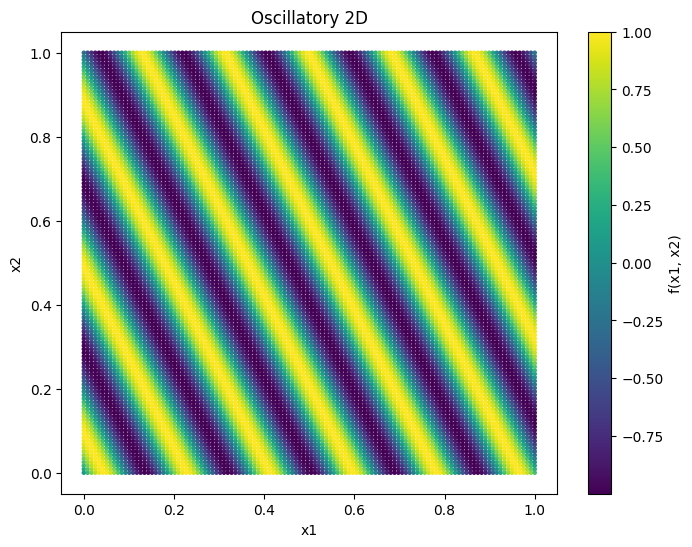

Training done! Time elapsed: 38.55 seconds
Test Loss: 0.5108135343
(0.0015013508984438803, 0.0005337301359236337, 0.000527308605801878)
Iteration 2 is running!


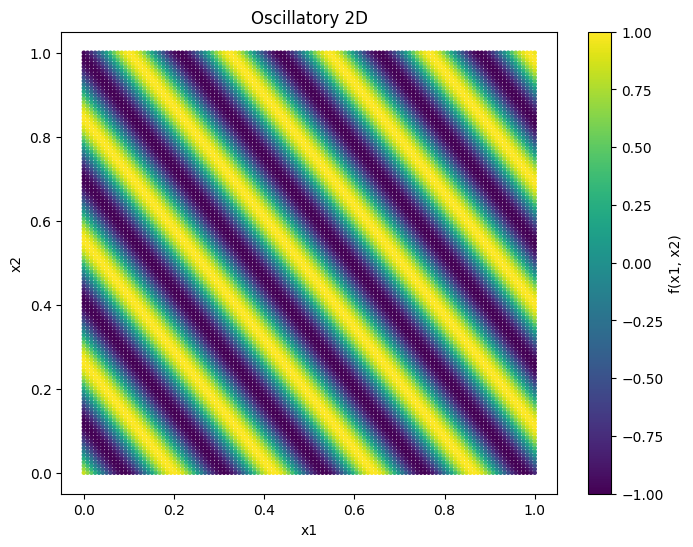

Training done! Time elapsed: 42.36 seconds
Test Loss: 0.4893564582
(-0.0029515743261888296, -0.005760547722455453, -0.005698305167839263)
Iteration 3 is running!


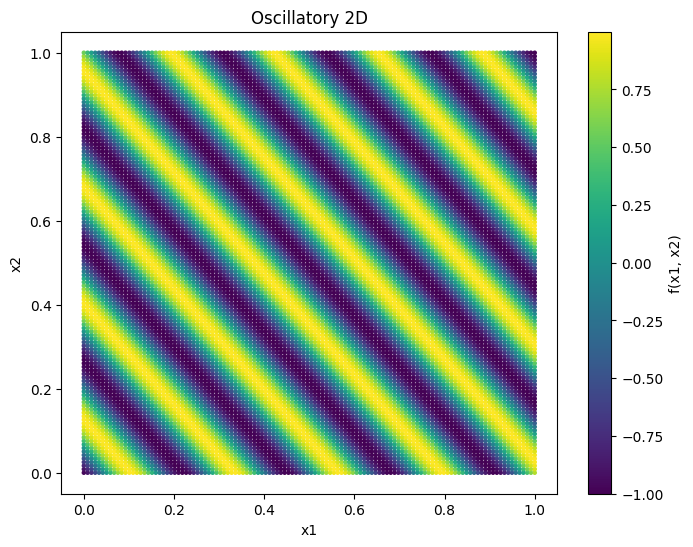

Training done! Time elapsed: 40.62 seconds
Test Loss: 0.5046112537
(0.0032316762545795824, 0.005308473146789542, 0.0052516590092346535)
Iteration 4 is running!


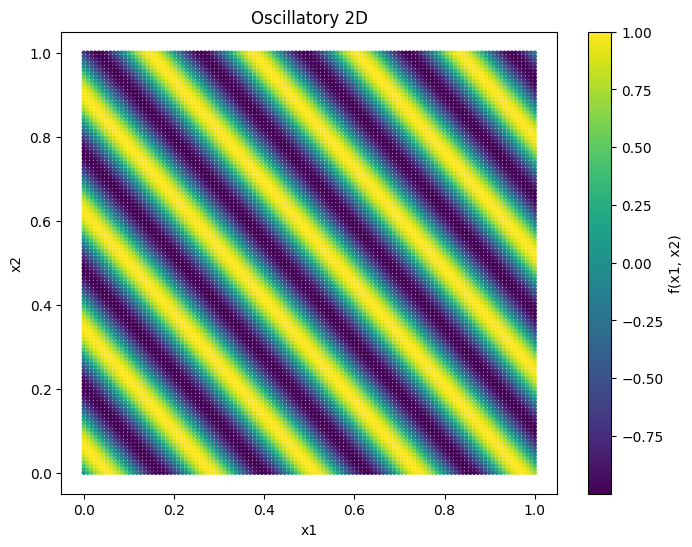

Training done! Time elapsed: 39.77 seconds
Test Loss: 0.4950997233
(0.000822819330794089, 0.00035653001000728957, 0.0003527117937346723)
Iteration 5 is running!


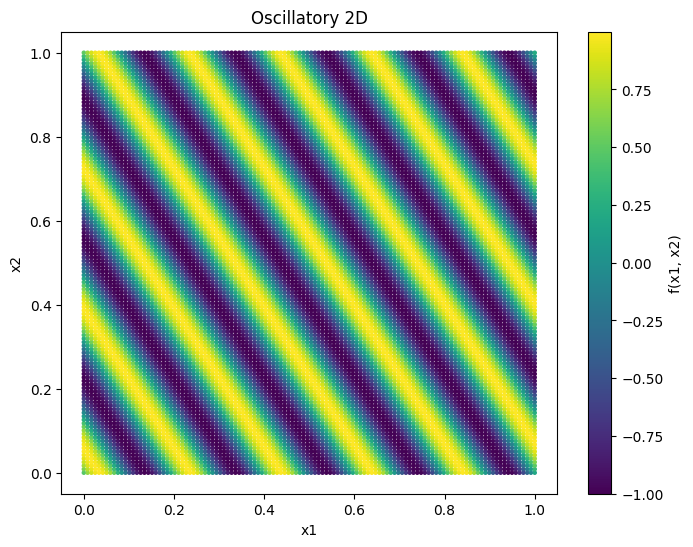

Training done! Time elapsed: 39.03 seconds
Test Loss: 0.4962789714
(0.0014454275607145434, -7.059163943974188e-06, -6.979722646707941e-06)
Iteration 6 is running!


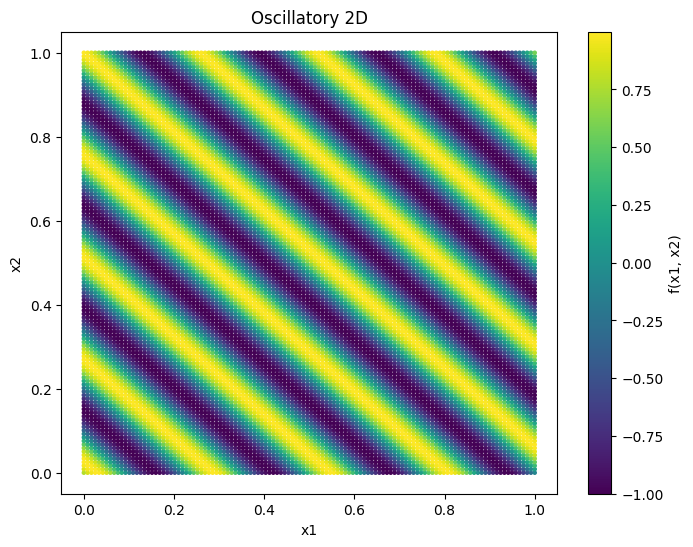

Training done! Time elapsed: 38.91 seconds
Test Loss: 0.4817406535
(-0.0018646672507165105, -0.0006851644651164287, -0.0006778859173665206)
Iteration 7 is running!


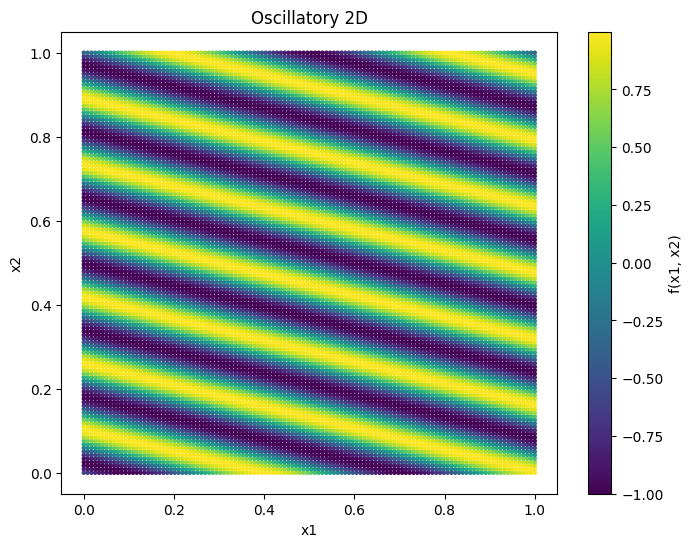

Training done! Time elapsed: 40.07 seconds
Test Loss: 0.5051321387
(0.006588997725336505, 0.0037564403951979453, 0.0037024208354092866)
Iteration 8 is running!


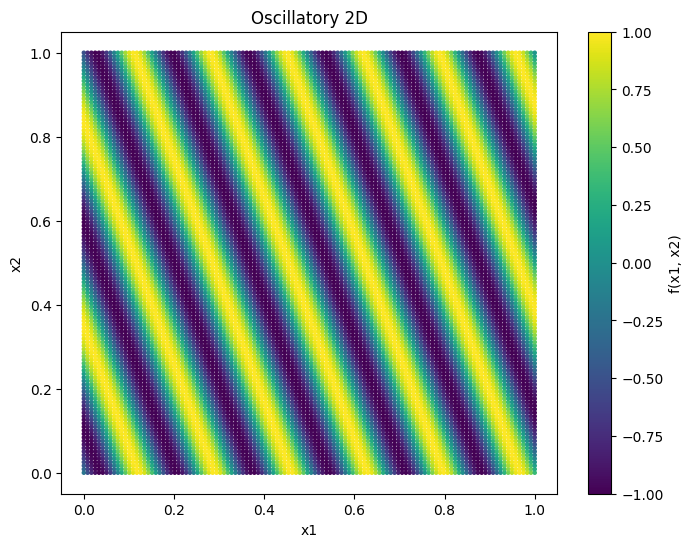

Training done! Time elapsed: 39.74 seconds
Test Loss: 0.5192509294
(0.003607220003463224, 3.156316481959584e-05, 3.114844400845553e-05)
Iteration 9 is running!


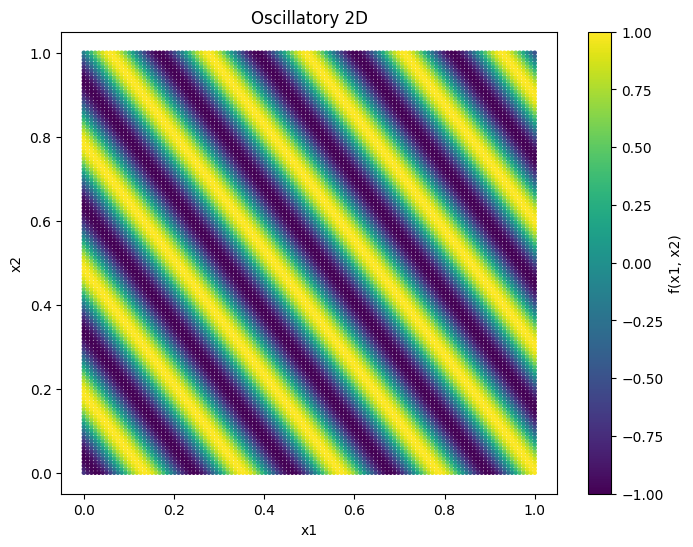

Training done! Time elapsed: 40.07 seconds
Test Loss: 0.4961533844
(0.0033181336251309895, 0.003332707479585883, 0.0032964644264607402)
Iteration 10 is running!


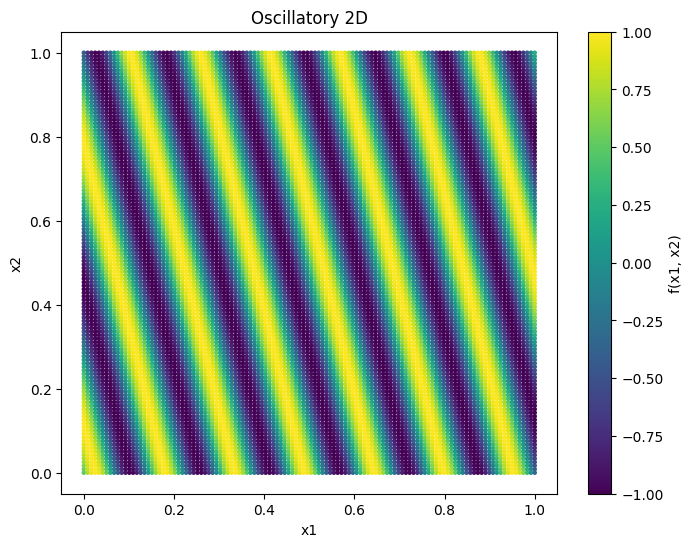

Training done! Time elapsed: 38.99 seconds
Test Loss: 0.4908461571
(-0.006132321019738478, -0.003933336121679253, -0.003875034327876513)


In [12]:
results = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results.append(test_osc_2d(i, h=100))
    print(results[i])

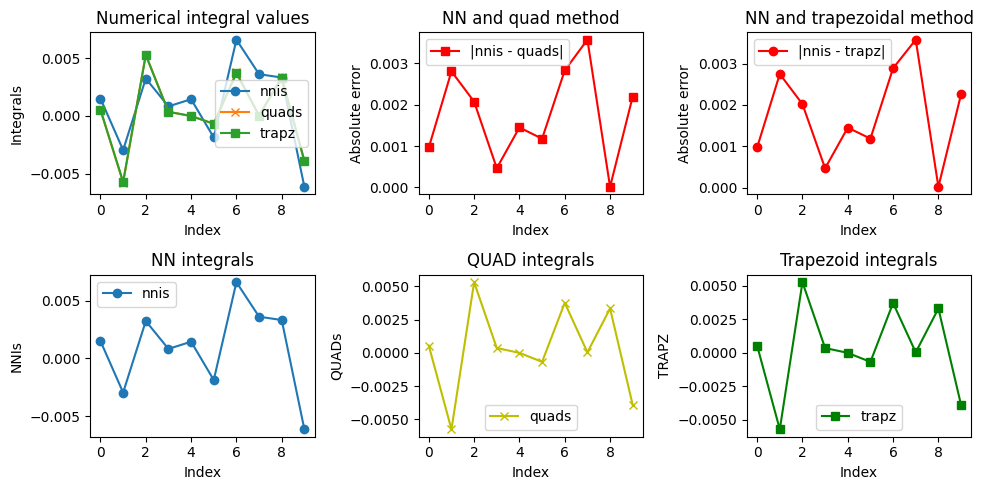

In [15]:
plot_test_results(results)

# Corner Peak 2D

In [16]:
def test_osc_2d(iteration_index: int, h: float, ej: float = 1):
    dim = 2
    u = [random.uniform(0, 1) for _ in range(dim)]
    cs = [random.uniform(0, 1) for _ in range(dim)]
    fraction = h / (dim ** ej * sum(cs))
    c = [fraction * value for value in cs]
    
    def corn_peek_2d(X):
        sum_ = 0
        for i in range(2):
            sum_ += c[i] * X[:, i]
        return (1 + sum_) ** (-3)

    def corn_peek_2d_float(X):
        sum_ = 0
        for i in range(2):
            sum_ += c[i] * X[i]
        return (1 + sum_) ** (-3)
  
    X, y = generate_data(corn_peek_2d, params=[u, c], lower=[a, a], upper=[b, b], n_samples=120, n_dim=dim)

    
    x1_coords = X[:, 0].numpy()
    x2_coords = X[:, 1].numpy()
    values = y.squeeze().numpy()
    values_log = np.log(values + 0.000000001)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x1_coords, x2_coords, c=values_log, cmap='viridis', s=5, vmin=np.min(values_log), vmax=np.max(values_log))  # Use 'c' for color mapping
    plt.colorbar(label='ln(f(x1, x2)+c)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Corner Peak 2D')
    plt.show()
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    
    model = MLP(input_size, hidden_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs, verbose=False)
    
    test_loss = test_model(model, criterion, x_test, y_test)
    print(f"Test Loss: {test_loss:.10f}")
    
    bs1, we1, bs2, we2 = extract_model_params_2d(model)
    nni = get_2D_NN_integral(a, b, a, b, bs1, we1, bs2, we2)
    result_quad = integrate_2d_nquad(corn_peek_2d_float, lower=[a, a], upper=[b, b])
    result_trapz = integrate_2d_trapz(corn_peek_2d, lower=[a, a], upper=[b, b])
   
    return float(nni[0]), result_quad, result_trapz

Iteration 1 is running!


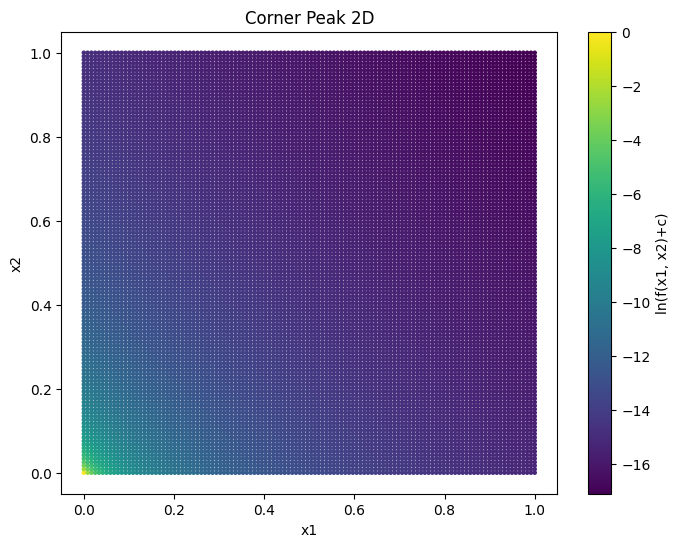

Training done! Time elapsed: 37.58 seconds
Test Loss: 0.0000002964
(9.778994968008548e-05, 2.2090731050972606e-05, 4.321442707942794e-05)
Iteration 2 is running!


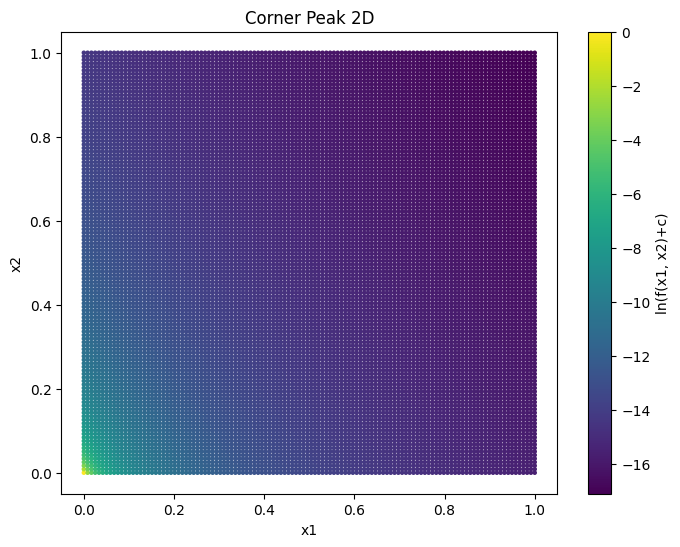

Training done! Time elapsed: 37.15 seconds
Test Loss: 0.0006932538
(3.38995413687454e-05, 2.2956943746734503e-05, 4.4552153697626034e-05)
Iteration 3 is running!


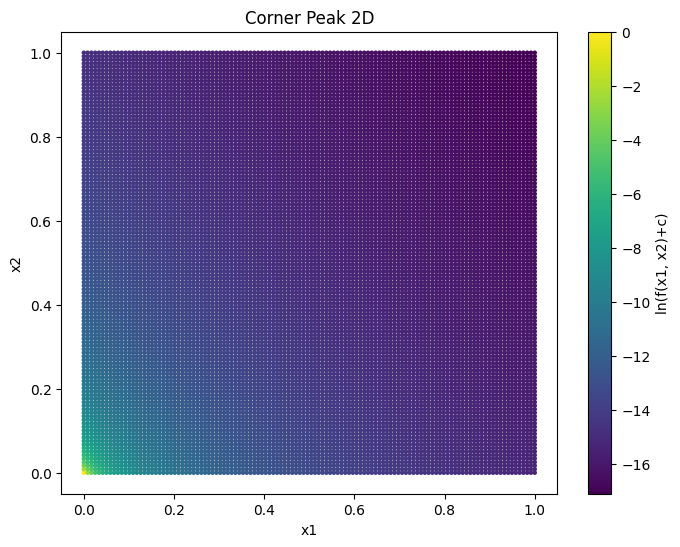

Training done! Time elapsed: 36.91 seconds
Test Loss: 0.0006934062
(3.303723474476494e-05, 2.2183465089111362e-05, 4.3356641221830675e-05)
Iteration 4 is running!


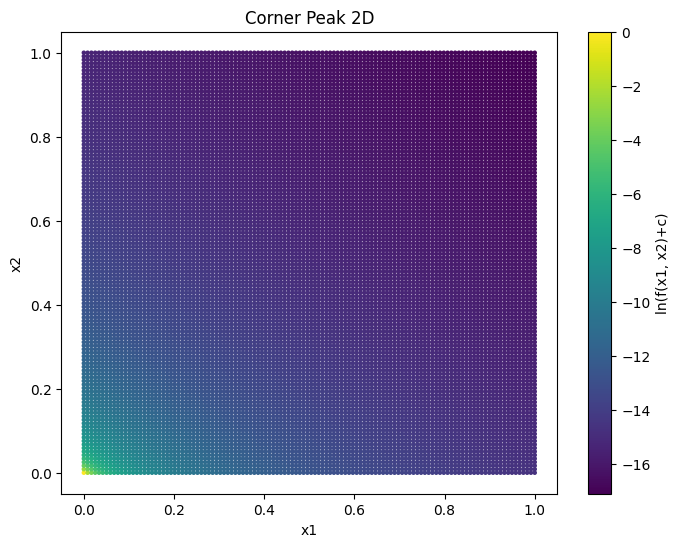

Training done! Time elapsed: 37.53 seconds
Test Loss: 0.0000001603
(0.00011300231367113167, 2.232577256208916e-05, 4.3575355071530956e-05)
Iteration 5 is running!


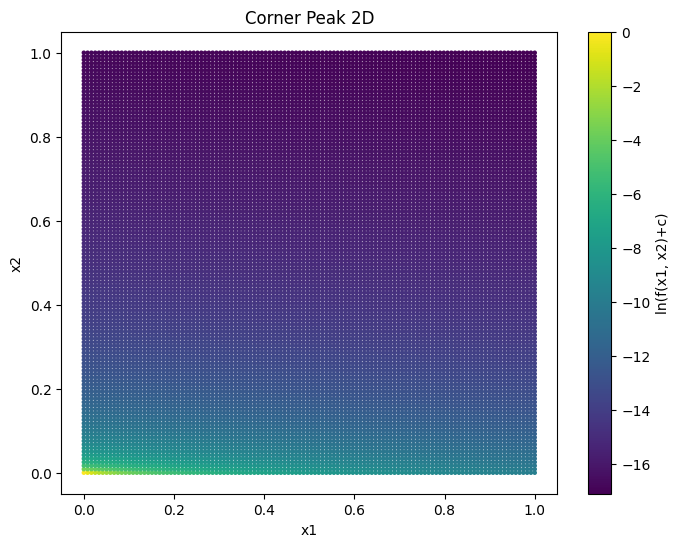

Training done! Time elapsed: 38.01 seconds
Test Loss: 0.0000008178
(0.00014380649716905225, 6.9216957903976e-05, 0.0001279781226658498)
Iteration 6 is running!


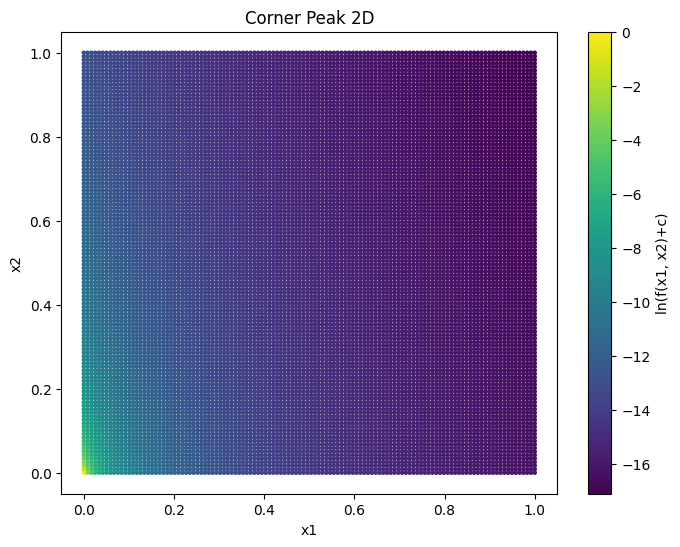

Training done! Time elapsed: 38.18 seconds
Test Loss: 0.0000006149
(0.00012182722599529683, 2.9489683519562234e-05, 5.518250460082088e-05)
Iteration 7 is running!


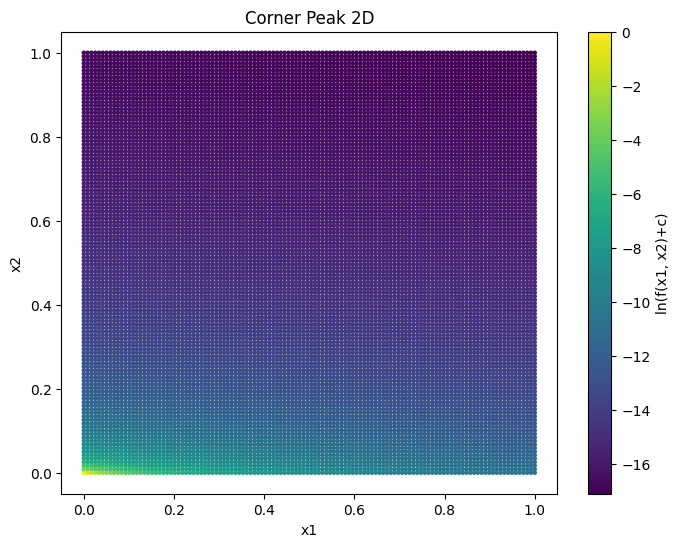

Training done! Time elapsed: 37.37 seconds
Test Loss: 0.0000013563
(0.00019092001403419462, 5.40172482547557e-05, 9.925097453155384e-05)
Iteration 8 is running!


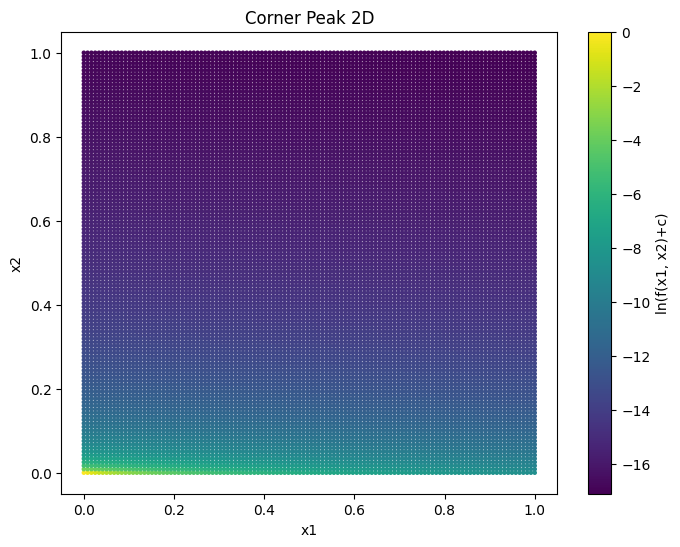

Training done! Time elapsed: 38.64 seconds
Test Loss: 0.0000113983
(0.00034409390127368433, 9.832069795400622e-05, 0.0001844546937948017)
Iteration 9 is running!


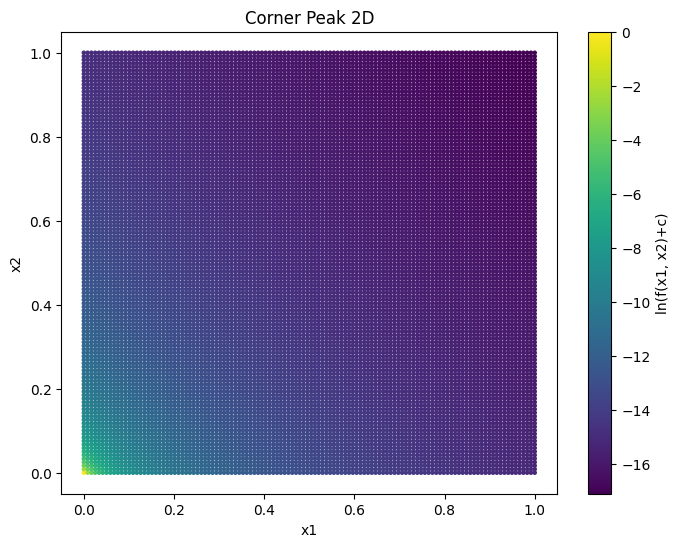

Training done! Time elapsed: 38.59 seconds
Test Loss: 0.0000004243
(0.00011356742836521327, 2.2050549213870868e-05, 4.3152882029964694e-05)
Iteration 10 is running!


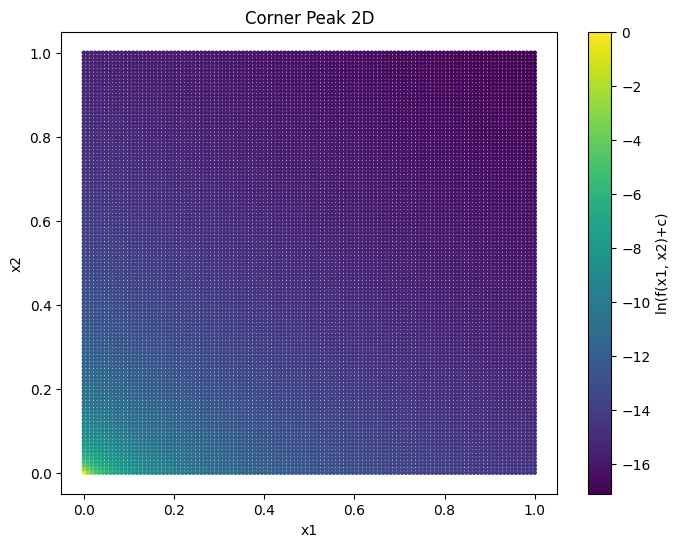

Training done! Time elapsed: 37.26 seconds
Test Loss: 0.0000001013
(8.975283065455752e-05, 2.2603375760331643e-05, 4.400363539489609e-05)


In [17]:
results = []
for i in range(10):
    print(f"Iteration {i+1} is running!")
    results.append(test_osc_2d(i, h=600))
    print(results[i])

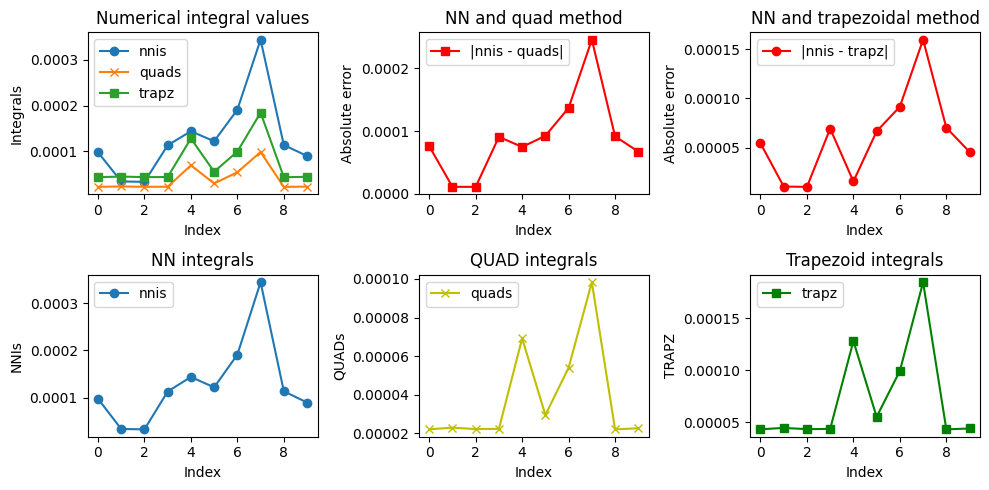

In [18]:
plot_test_results(results)